In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import torch
sys.path.append('../../../src/')

from m3_learning.viz.layout import layout_fig
from m3_learning.RHEED.Viz import Viz
from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy
from m3_learning.RHEED.Fitter1D import Model, Multiscale1DFitter


def collect_data(ys_nor_all, mean_length=2000, viz=False):

    ys_all_same_length = []
    for y in ys_nor_all:
        ys_all_same_length.append(np.interp(np.linspace(0, 1, mean_length), np.linspace(0, 1, len(y)), y))

    ys_all_same_length = np.array(ys_all_same_length)
    ys = torch.tensor(ys_all_same_length).float().unsqueeze(1)

    x = np.linspace(0, 1, mean_length)
    x = torch.tensor(x).float().unsqueeze(0)

    xs = x.repeat(ys.shape[0], 1, 1).squeeze().detach().numpy()
    if viz:
        print(xs.shape, ys.shape)
        Viz.plot_fit_details(xs, ys.squeeze().detach().numpy(), ys.squeeze().detach().numpy(), None, mod=5, labels=None, figsize=(12, 1.5*len(xs)//4+1), style='presentation')
    return xs, ys

def viz_fit(model, batch, device):
    inputs = batch[0].to(device).double()
    model = model.to(device).double()
    outputs, unscaled_param = model(inputs)
    labels = []
    for param in unscaled_param:
        labels.append(f'I/I0 = {param[0]:.2f} * 1-exp(-x/{param[1]:.2e})')

    xs = x.repeat(outputs.shape[0], 1, 1).squeeze().detach().cpu().numpy()
    ys = inputs.squeeze().detach().cpu().numpy()
    ys_fit = outputs.squeeze().detach().cpu().numpy()
    # print(xs.shape, ys.shape, ys_fit.shape)
    Viz.plot_fit_details(xs, ys, ys_fit, None, mod=5, labels=labels, figsize=(12, 1.5*len(xs)//4+1), style='presentation')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
para_path = '../datasets/J14_PM04_05_06_gaussian_fit_parameters_10022023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=2000, sample_name='J14')
ds_para.dataset_names

['temp250',
 'temp250_later_stage',
 'temp300',
 'temp300_later_stage',
 'temp350',
 'temp350_later_stage']

../Datasets/J14_PM04_05_06_gaussian_fit_parameters_10022023.h5 temp250


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
../../../src\m3_learning\RHEED\Analysis_umich.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_all = np.array(ys_nor_all)
../../../src\m3_learning\RHEED\Analysis_umich.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_fit_all = np.ar

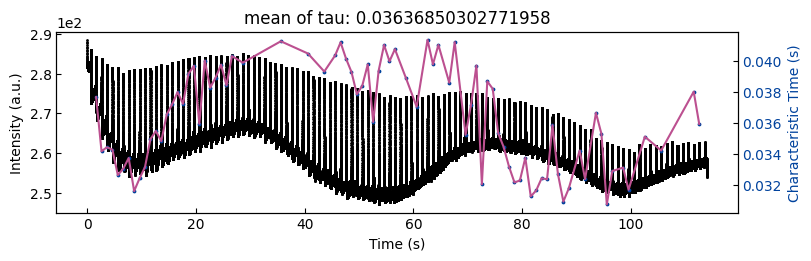

../Datasets/J14_PM04_05_06_gaussian_fit_parameters_10022023.h5 temp250_later_stage


c:\Users\yig319\Anaconda3\envs\m3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


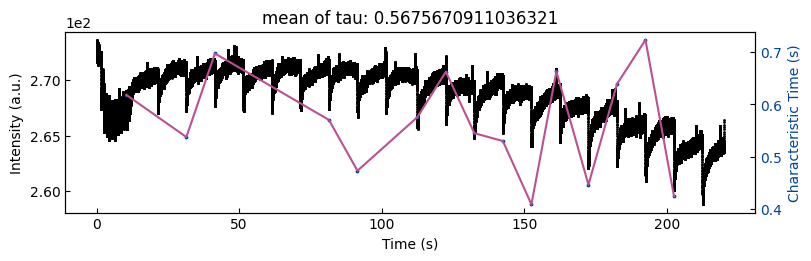

../Datasets/J14_PM04_05_06_gaussian_fit_parameters_10022023.h5 temp300


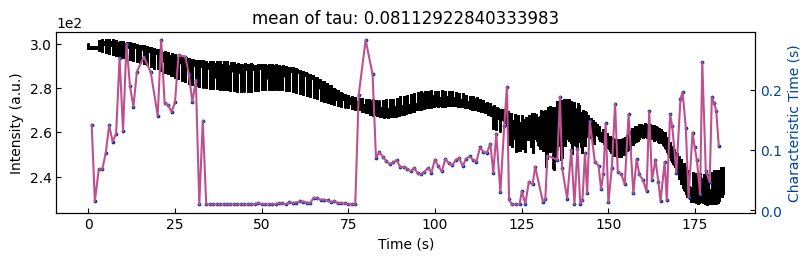

../Datasets/J14_PM04_05_06_gaussian_fit_parameters_10022023.h5 temp300_later_stage


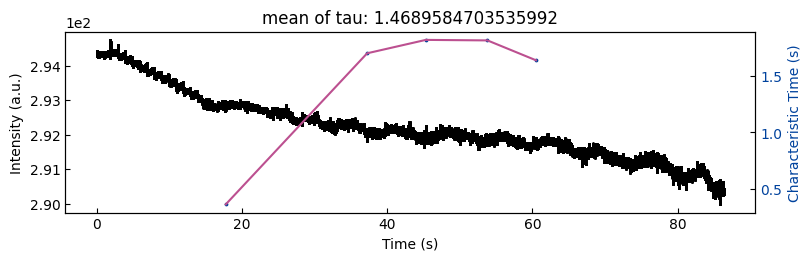

../Datasets/J14_PM04_05_06_gaussian_fit_parameters_10022023.h5 temp350


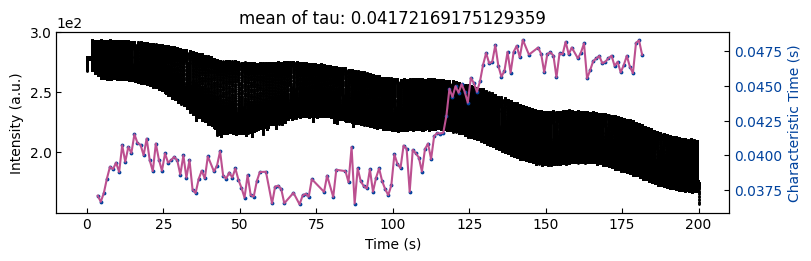

../Datasets/J14_PM04_05_06_gaussian_fit_parameters_10022023.h5 temp350_later_stage


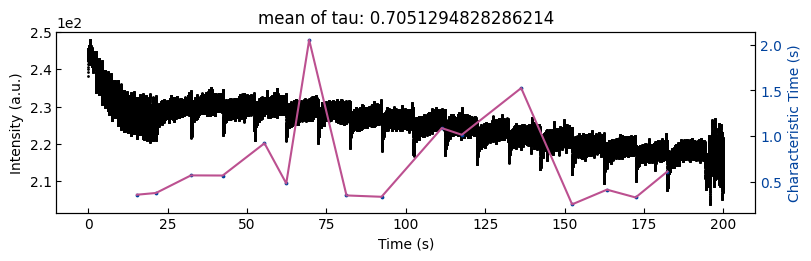

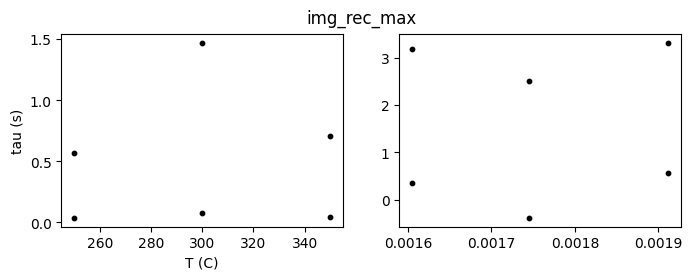

In [8]:
metric = 'img_rec_max'
spot = 'spot_2'
viz_params = {'viz_denoise': False, 'viz_raw_curves': False, 'viz_processed_curves':False, 'viz_fittings': False, 'viz_ab': False, 'viz_tau': True, 'per_plot':5}

ys_list, tau_list  = [], []
laser_freq_list = [1, 0.1, 1, 0.1, 1, 0.1]
camera_freq = 2000
ranges_list = [(0, 114), (0, 220), (0, 200), (0, 200), (0, 200), (0, 200)]
temp_list = ['temp250', 'temp250_later_stage', 'temp300', 'temp300_later_stage', 'temp350', 'temp350_later_stage']
T_list = [250, 250, 300, 300, 350, 350]
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}

para_path= '../Datasets/J14_PM04_05_06_gaussian_fit_parameters_10022023.h5'
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}

for temp, ranges, laser_freq in zip(temp_list, ranges_list, laser_freq_list):
    ds_para = RHEED_parameter_dataset(para_path, camera_freq=camera_freq, sample_name='J14')

    print(para_path, temp)
    sample_x, sample_y = ds_para.load_curve(growth=temp, spot=spot, metric=metric, x_start=0)
    data = np.stack([sample_x, sample_y], 1)
    data = select_range(data, *ranges)

    parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
    [xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info
    xs, ys = collect_data(ys_nor_all, mean_length=2000, viz=False)
    ys_list.append(ys)
    tau_list.append(tau)

tau_mean_list = np.array([np.mean(tau) for tau in tau_list])
plot_activation_energy(T_list, tau_mean_list, fit=False, title=metric)